In [1]:
#pip install pandas-datareader

In [2]:
#pip install --upgrade pip

In [3]:
#pip install tensorflow

In [4]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Getting the data

Three datasets of different lengths to explore with

In [5]:
df = web.DataReader('RECSI.OL', data_source='yahoo', start='2013-01-01')

In [6]:
df2 = web.DataReader('RECSI.OL', data_source='yahoo', start='2017-08-01')

In [7]:
df3 = web.DataReader('RECSI.OL', data_source='yahoo', start='2021-01-01')

# Exploring the data

In [8]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,11.890000,10.860000,11.17,11.700000,3988387.0,11.700000
2013-01-03,12.910000,11.440000,11.88,12.730000,8513722.0,12.730000
2013-01-04,13.690000,12.600000,12.76,12.900000,9699644.0,12.900000
2013-01-07,13.500000,12.900000,13.14,13.200000,4230711.0,13.200000
2013-01-08,13.050000,12.170000,13.00,12.510000,3042627.0,12.510000
...,...,...,...,...,...,...
2022-11-14,19.620001,19.000000,19.48,19.430000,3772699.0,19.430000
2022-11-15,20.080000,19.200001,19.26,19.860001,6384368.0,19.860001
2022-11-16,18.950001,17.760000,18.50,18.094999,14870941.0,18.094999


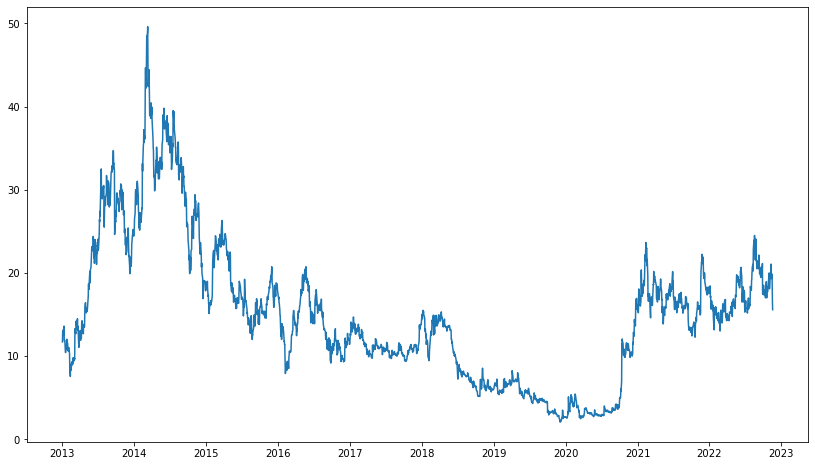

In [9]:
plt.figure(figsize=(14,8))
plt.plot(df['Close'])
plt.show()

# Processing the data

In [10]:
#Leaving only the Close price
data = df.drop(columns=['Adj Close','Open','High','Low','Volume'])

In [11]:
dates = data.index

In [12]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [13]:
X_raw, y_raw = train_test_split(data,train_size=0.85,shuffle=False)

In [14]:
#Saving the dates to correctly plot them
X_dates = dates[:len(X_raw)]
y_dates = dates[len(X_raw):]

In [15]:
# split a univariate sequence into samples 
# Thanks to Jason Brownlee https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [16]:
# define input sequence
raw_seq = X_raw
# choose a number of time steps
n_steps_in, n_steps_out = 30, 10
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

In [17]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = X.shape[2]
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Predicting on test data

In [18]:
# define model
# Thanks to Jason Brownlee https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=50, verbose=0)
# demonstrate prediction
x_input = np.array(y_raw)[:n_steps_in]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)

In [19]:
# inverse scaling to get the real values
yhat = scaler.inverse_transform(yhat)
print(yhat)
y_actual = scaler.inverse_transform(y_raw)

[[15.499394 15.664758 15.706401 15.706907 15.950766 15.645977 16.111216
  15.98211  16.251566 16.228142]]


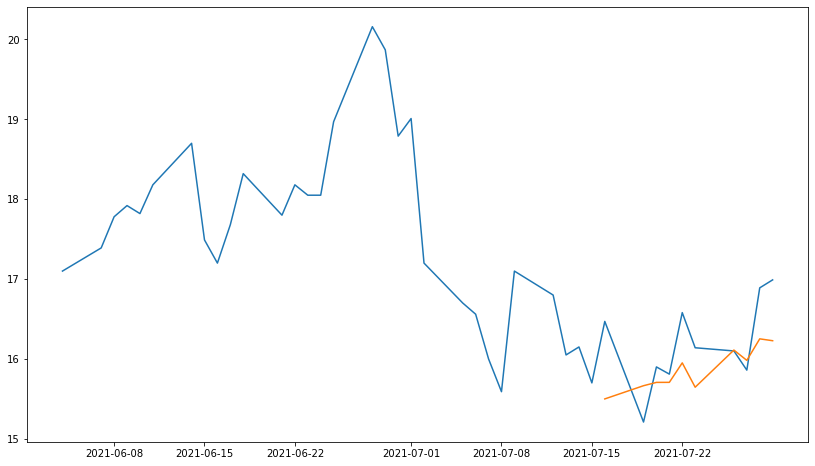

In [20]:
pred = pd.DataFrame(yhat[0], index=y_dates[n_steps_in:n_steps_out+n_steps_in])
test = pd.DataFrame(y_actual[:n_steps_out+n_steps_in], index = y_dates[:n_steps_out+n_steps_in])
plt.figure(figsize=(14,8))
plt.plot(test)
plt.plot(pred)
plt.show()

# Prediction metrics

In [21]:
def calculate_error (test, pred,window):
    tb = test.set_axis(['Actual'],axis=1)
    tb['Predicted'] = pred
    tb['MA_Test'] = test.rolling(window).mean()
    tb = tb.iloc[window-1:]
    test_mse = mean_squared_error(tb['MA_Test'],tb['Actual'])
    print('MSE for test data:')
    print(test_mse)
    pred_mse = mean_squared_error(tb['Predicted'].iloc[-n_steps_out:],tb['Actual'].iloc[-n_steps_out:])
    print('MSE for prediction data:')
    print(pred_mse)
    return tb

In [22]:
tb = calculate_error(test,pred,4)

MSE for test data:
0.36284378977096965
MSE for prediction data:
0.2840042609895136


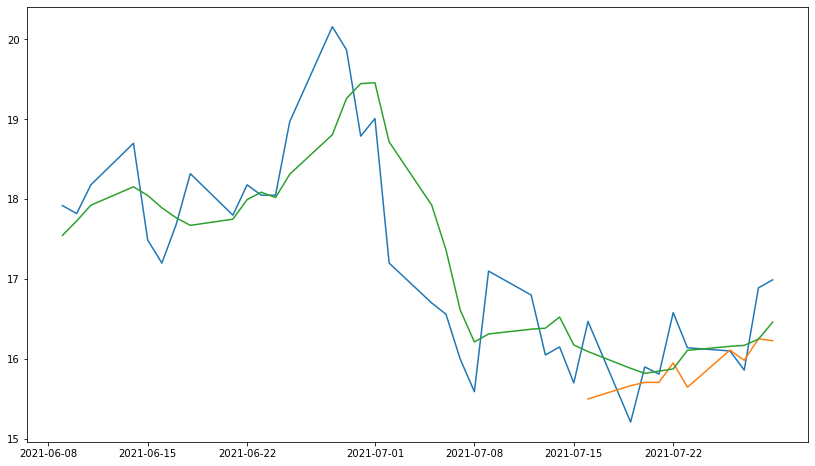

In [23]:
plt.figure(figsize=(14,8))
plt.plot(tb)
plt.show()

# Predicting the future

In [34]:
# define input sequence
raw_seq = data
# choose a number of time steps
n_steps_in, n_steps_out = 5, 20
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

In [35]:
last_n_values = y_raw[-n_steps_in:]
last_n_values

array([[0.36524302],
       [0.37428995],
       [0.33715548],
       [0.30254579],
       [0.28413634]])

In [36]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = X.shape[2]
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [37]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=50, verbose=0)
# demonstrate prediction
x_input = np.array(last_n_values)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)

In [38]:
yhat = scaler.inverse_transform(yhat)
print(yhat)
y_actual = scaler.inverse_transform(y_raw)

[[16.690191 16.809431 16.887197 16.910513 16.897804 16.79174  16.861116
  16.761213 16.723114 16.999222 17.00484  16.996344 17.220177 17.210936
  17.150219 17.438837 17.32567  17.170292 17.379488 17.354708]]


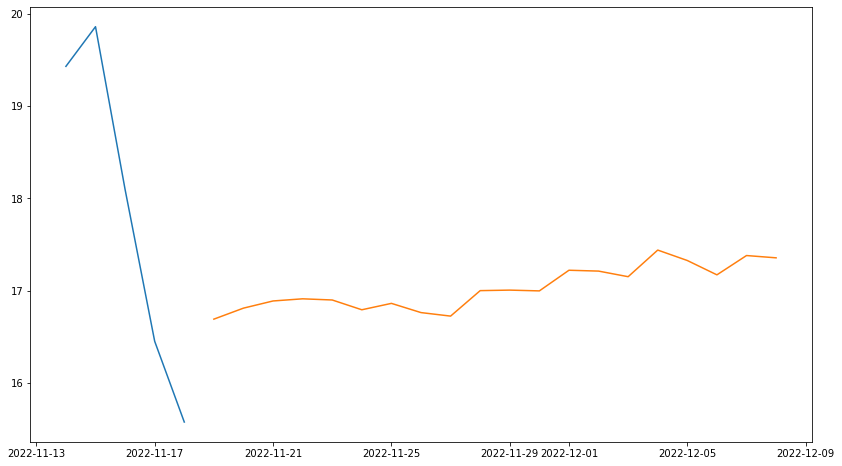

In [41]:
ind = pd.date_range(start=(y_dates[-1:])[0],periods=n_steps_out)
ind = ind.shift(1,freq='D')
pred = pd.DataFrame(yhat[0],index=ind)
test = pd.DataFrame(y_actual[-n_steps_in:], index = y_dates[-n_steps_in:])
plt.figure(figsize=(14,8))
plt.plot(test)
plt.plot(pred)
plt.show()
# it appears the model is missing the last test value. further investigation is required to confirm. 